In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import sys
sys.path.append("..")

In [10]:
import numpy as np
import pandas as pd
import pickle
from src.mc.MonteCarlo import MonteCarlo
from src.mc.MC import MC_set
from src.mc.shape_ext import shape_generator
from src.utils import tools as fg

### Extract shapes

In [4]:
# required files
# calib.npy and shaula_00000-003_ch0.npy
select_files = shape_generator('../src/data/calib_ch0.npy', '../src/data/shaula_00000-003_ch0.npy','../src/data/')
generate_shapes = select_files.generator(bin_num=214748300)
shapes, save_path = select_files.scalar(generate_shapes)
# generated file
# shaula_00000-003_ch0_shapes.npy

C:\Users\jigar\Desktop\projects\27023-corr-mc\notebooks\..\src\mc\shape_ext.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asarray(val)
C:\Users\jigar\Desktop\projects\27023-corr-mc\notebooks\..\src\mc\shape_ext.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ind_side = np.asarray(ind_side)


### Exploratory data analysis

In [3]:
uniq_shape = np.load('../src/data/shaula_00000-003_ch0_shapes.npy')

In [7]:
# Generate data of extracted pulse, individually; pulse height, pulse width, skewness, kurtosis in dataframe format
df = fg.pulse_data(uniq_shape)

In [8]:
df.to_csv('../src/data/calib_pulse_data.csv')

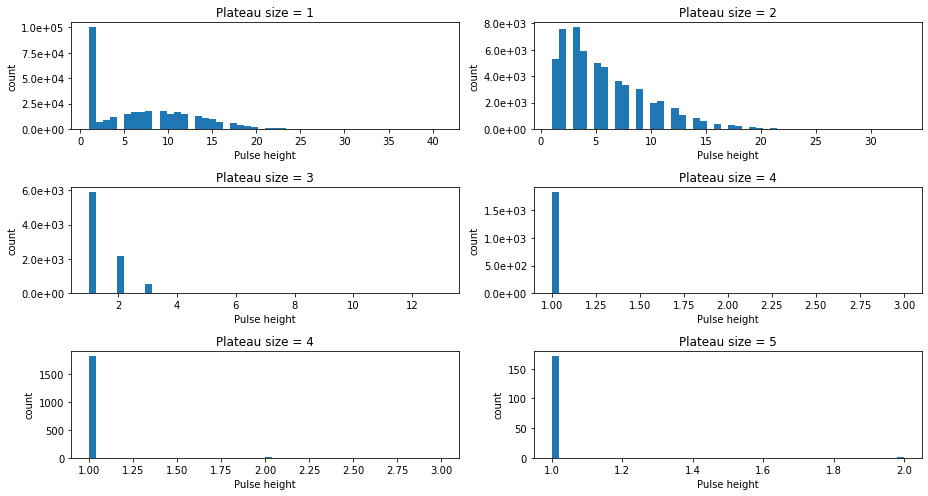

In [4]:
df = pd.read_csv('../src/data/calib_pulse_data.csv')
fg.plat_plot(df, 50,'../plots/')

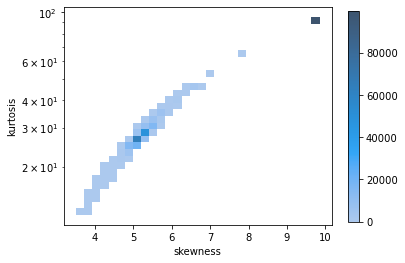

In [23]:
fg.skew_kurt(df, 1, '../plots/')

In [6]:
platauless_uniq_shapes, uniq_shapes = fg.filter_shapes_based_on_plat_size(df, uniq_shape, platau_removal=True, lst=[3,4,5], save_path='../src/data/')

In [7]:
print(f'after removal of shapes with plateau : {platauless_uniq_shapes.shape[0]}')
print(f'after removal of shapes with plateau and duplicates : {len(uniq_shapes)}')
print(f'Difference {len(uniq_shapes)-platauless_uniq_shapes.shape[0]}')

after removal of shapes with plateau : 371814
after removal of shapes with plateau and duplicates : 382495
Difference 10681


 - There are 382,495 shapes extracted from calibration file
 - These shapes could be repetative, i.e not unique
 - There could be shapes with pletau(2 or more bins),
   such shapes can be considered as resultant shape of multiple pulses,
   and can not be considered as single pulse shape
   
 - After applying plateau removal function remaining shapes are 316162 (82% of total calib shapes)
 - out of which if identicals are removed then, number of unique shapes are 19269 (5% of calib shapes and 6% of calib shapes without plateau)

### Generate data

In [18]:
# Required files: MC.py, monte_carlo.py and pulse shape file in 
# .npy format(here plateauless_uniq_pulses.npy)

def generator(samp_size,max_rate,name, train_exe):
    
    '''
    This function generates MC data for training, testing and validation,
    and save them to "./DATASETS/sub_folder_name/" path.
    
    All dataset are generated using given pulse shapes, unlike separate splitting
    of set of pulse shapes for train, test and val data generation.
    
    Test and val data has similar size(however can be changed in this function)
    The ratio between training dataset size and validation dataset size is 0.33 here.
    
    All datasets has specific format: range of rate(in photon number) with desired
    number of sample examples for each rate.
    '''
    
    name1 = name.split('.')[0]
    folder_name = 'sh06x2'
    val_exe = test_exe = int(train_exe*0.33)
    
    
    x = MC_set(name, max_rate, train_exe, samp_size)
    remove_duplicates = x.remove_duplicate_pulse()
    train,evaluation = x.train_test_val_split(60,40)
    train_x, train_y, train_x1, train_y1, CORR_pattern, CH0_ind, CH1_ind = x.get_mc_set(remove_duplicates)
    np.save(f'../DATASETS/{folder_name}/lab_ch0_shapes_train_x_m_{train_exe}.npy',train_x)
    np.save(f'../DATASETS/{folder_name}/lab_ch0_shapes_train_y_m_{train_exe}.npy',train_y)
    
    np.save(f'../DATASETS/{folder_name}/lab_ch1_shapes_train_x_m_{train_exe}.npy',train_x1)
    np.save(f'../DATASETS/{folder_name}/lab_ch1_shapes_train_y_m_{train_exe}.npy',train_y1)
    
    with open(f'../DATASETS/{folder_name}/lab_ch0_1_shapes_train_CORR_pattern_{train_exe}', 'wb') as fp:
        pickle.dump(CORR_pattern, fp)
    with open(f'../DATASETS/{folder_name}/lab_shapes_train_CH0_ind_{train_exe}', 'wb') as ch0p:
        pickle.dump(CH0_ind, ch0p)
    with open(f'../DATASETS/{folder_name}/lab_shapes_train_CH1_ind_{train_exe}', 'wb') as ch1p:
        pickle.dump(CH1_ind, ch1p) 
        
    
    x = MC_set(name, max_rate, test_exe, samp_size)
    remove_duplicates = x.remove_duplicate_pulse()
    train,evaluation = x.train_test_val_split(60,40)
    test_x, test_y, test_x1, test_y1, CORR_pattern, CH0_ind, CH1_ind = x.get_mc_set(remove_duplicates)
    np.save(f'../DATASETS/{folder_name}/lab_ch0_shapes_test_x_m_{train_exe}.npy',test_x)
    np.save(f'../DATASETS/{folder_name}/lab_ch0_shapes_test_y_m_{train_exe}.npy',test_y)
    
    np.save(f'../DATASETS/{folder_name}/lab_ch1_shapes_test_x_m_{train_exe}.npy',test_x1)
    np.save(f'../DATASETS/{folder_name}/lab_ch1_shapes_test_y_m_{train_exe}.npy',test_y1)
    
    with open(f'../DATASETS/{folder_name}/lab_ch0_1_shapes_test_CORR_pattern_{train_exe}', 'wb') as fp:
        pickle.dump(CORR_pattern, fp)
    with open(f'../DATASETS/{folder_name}/lab_shapes_test_CH0_ind_{train_exe}', 'wb') as ch0p:
        pickle.dump(CH0_ind, ch0p)
    with open(f'../DATASETS/{folder_name}/lab_shapes_test_CH1_ind_{train_exe}', 'wb') as ch1p:
        pickle.dump(CH1_ind, ch1p)
    
    
    x = MC_set(name, max_rate, val_exe, samp_size)
    remove_duplicates = x.remove_duplicate_pulse()
    train,evaluation = x.train_test_val_split(60,40)
    val_x, val_y, val_x1, val_y1, CORR_pattern, CH0_ind, CH1_ind = x.get_mc_set(remove_duplicates)
    np.save(f'../DATASETS/{folder_name}/lab_ch0_shapes_val_x_m_{train_exe}.npy',val_x)
    np.save(f'../DATASETS/{folder_name}/lab_ch0_shapes_val_y_m_{train_exe}.npy',val_y)
    
    np.save(f'../DATASETS/{folder_name}/lab_ch1_shapes_val_x_m_{train_exe}.npy',val_x1)
    np.save(f'../DATASETS/{folder_name}/lab_ch1_shapes_val_y_m_{train_exe}.npy',val_y1)
    
    with open(f'../DATASETS/{folder_name}/lab_ch0_1_shapes_val_CORR_pattern_{train_exe}', 'wb') as fp:
        pickle.dump(CORR_pattern, fp)
    with open(f'../DATASETS/{folder_name}/lab_shapes_val_CH0_ind_{train_exe}', 'wb') as ch0p:
        pickle.dump(CH0_ind, ch0p)
    with open(f'../DATASETS/{folder_name}/lab_shapes_val_CH1_ind_{train_exe}', 'wb') as ch1p:
        pickle.dump(CH1_ind, ch1p)
        
        
    
    print(train_x.shape,val_x.shape,test_x.shape)
    print(train_y.shape,val_y.shape,test_y.shape)

train_exe = 50
name = '../src/data/plateauless_uniq_pulses_345.npy'
samp_size = 256
max_num_photon = 60
generator(samp_size, max_num_photon, name, train_exe)

Total unique shapes:21886
Total unique shapes:21886


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.68it/s]


Total unique shapes:21886
Total unique shapes:21886


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.10it/s]


Total unique shapes:21886
Total unique shapes:21886


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.05it/s]


(3000, 256) (960, 256) (960, 256)
(3000, 256) (960, 256) (960, 256)
